In [69]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image
from scipy import stats

## Inserez les chemins vers le fichiers CSV:

In [70]:
# on récupère les informations du dossier
dossier = './raw_data'
contenuDossier = os.listdir(dossier)
print(contenuDossier)
nombrePoints = 0
nomPoints = []
numeroPoints = []
# on parcours le dossier en recherchant les fichiers des points
for x in contenuDossier:
    if x.startswith('point') :
        nombrePoints += 1
        nomPoints.append(x)
        numeroPoints.append(x[5:7])
print(numeroPoints)

['point14_29_07_15', 'point15_29_07_15', '.DS_Store', 'schema_dispositif_AvAv_23_07_15.png', 'point47_27_08_19', 'point13_29_07_15', 'point36_12_07_16', 'point46_17_06_19', 'point34_27_06_16', 'point48_14_04_18']
['14', '15', '47', '13', '36', '46', '34', '48']


In [71]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

In [72]:
# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
data = {}
for x in nomPoints :
    dico = {}
    # le numéro
    dico['numero'] = x[5:7]
    # le nom
    dico['nom'] = x
    # la date
    dico['date'] = x[8:18]
    # le chemin vers le dossier
    dico['chemin'] = dossier + '/' + x
    with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
        lignes = fichier.readlines()
        # le nom du capteur
        dico['capteur'] = lignes[1][:4]
        # la profondeur du capteur
        if lignes[3] == '\n' :
            dico['profondeur'] = 0
        else : 
            dico['profondeur'] = lignes[3]
        # les profondeurs auquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))
    # on va ensuite mettre les dataframes dans le dictionnaire
    contenuDossierPoint = os.listdir(dico['chemin'])
    for x in contenuDossierPoint:
        # la pression
        if (x.startswith('p') and x.endswith('.csv')) and not x.endswith('cleaned.csv') :
            dico['pression'] = read_csv(dico['chemin'] + '/' + x)
        # la température
        if x.startswith('t') and x.endswith('.csv'):
            dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
    # dans les configurations du capteur on va chercher les données
    chemin_etalonnage = 'configuration/pressure_sensors/P' + dico['capteur'][1:] +'.csv'
    if os.path.exists(chemin_etalonnage):
        with open(chemin_etalonnage) as fichier :
            lignes = fichier.readlines()
            for l in lignes :
                if l.startswith('Intercept') :
                    dico['intercept'] = float(l[10:-2])
                if l.startswith('dU/dH') :
                    dico['dU/dH'] = float(l[6:-2])
                if l.startswith('dU/dT') :
                    dico['dU/dT'] = float(l[6:-2]) 
    data[dico['numero']] = dico


In [73]:
data['46']['pression']['Date Heure, GMT+01:00'].is_monotonic_increasing
#data[5]['numero']

False

In [74]:
# en faisant data[0] on a accès à toutes les informations du point 1
data['13']

{'numero': '13',
 'nom': 'point13_29_07_15',
 'date': '29_07_15',
 'chemin': './raw_data/point13_29_07_15',
 'capteur': 'p505',
 'profondeur': 0,
 'profondeurMesures': [10, 20, 30, 40],
 'pression':        # Date Heure, GMT+02:00  \
 0      1  07/23/15 02:00:00 PM   
 1      2  07/23/15 02:15:00 PM   
 2      3  07/23/15 02:30:00 PM   
 3      4  07/23/15 02:45:00 PM   
 4      5  07/23/15 03:00:00 PM   
 ..   ...                   ...   
 558  559  07/29/15 09:30:00 AM   
 559  560  07/29/15 09:45:00 AM   
 560  561  07/29/15 10:00:00 AM   
 561  562  07/29/15 10:15:00 AM   
 562  563  07/29/15 10:30:00 AM   
 
      Tension, V (LGR S/N: 10117169, SEN S/N: 10117169)  \
 0                                              0.58181   
 1                                              0.58059   
 2                                              0.57937   
 3                                              0.57937   
 4                                              0.57937   
 ..                       

# Est ce que les fichiers peuvent être utilisés ?

**Dans notre cas, nous prendrons ces solutions**

* S'il manque toutes les données du capteurs de pression ou l'étalonnage, nous déciderons que ce point est invalide.
* S'il manque une partie des données nous vérifierons que nous avons au mimimun 7 jours de données
* S'il manque plus de 2 capteurs de température, nous déciderons que ce point est invalide.

### Est ce que nous avons les données de l'étalonnage du capteur ?

In [75]:
for x in data.values()  :
    if not 'intercept' in x.keys() :
        print('le point '+ x['numero'] + ' n\'a pas d\'étalonnage, il n\'est pas valide')
        data.remove(x)

### Est ce que nous avons des données pour le capteur de pression ?

In [76]:
for x in data.values() :
    if x['pression'].empty :
        print('le point '+ x['numero'] + ' n\'a pas de données de pression, il n\'est pas valide')
        data.remove(x)

In [77]:
data['13']['pression']

,#,"Date Heure, GMT+02:00","Tension, V (LGR S/N: 10117169, SEN S/N: 10117169)","Temp., °C (LGR S/N: 10117169, SEN S/N: 10117169)"
0,1,07/23/15 02:00:00 PM,0.58181,18.129
1,2,07/23/15 02:15:00 PM,0.58059,18.081
2,3,07/23/15 02:30:00 PM,0.57937,18.033
3,4,07/23/15 02:45:00 PM,0.57937,18.224
4,5,07/23/15 03:00:00 PM,0.57937,18.247
...,...,...,...,...
558,559,07/29/15 09:30:00 AM,0.54884,14.194
559,560,07/29/15 09:45:00 AM,0.54884,14.242
560,561,07/29/15 10:00:00 AM,0.54884,14.194
561,562,07/29/15 10:15:00 AM,0.54884,14.625


### On modifie les nom des colonnes du dataframe

In [78]:
# pour les températures
for x in data.values() :
    # on supprime les colonnes qui ne servent à rien
    for i in x['temperature'].columns :
        if not( i.startswith(('Date', 'dates', 'temp','Temp'))) :
            del x['temperature'][i]
    for i in x['pression'].columns :
        if not( i.startswith(('Date', 'dates', 'Tension', 'tension', 'pressure', 'temp', 'Temp'))) :
            del x['pression'][i]
    # on renomme les colonnes
    profondeur = x['profondeurMesures']
    colonnesT = ['dates']
    for num in profondeur :
        colonnesT.append('Temp_profondeur_'+ str(num))
    x['temperature'].columns = colonnesT
    colonnesP = ['dates', 'tension', 'temperature_stream']
    x['pression'].columns = colonnesP
    

In [79]:
# notamment la température et la pression
data['14']['temperature'].head(5)

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,07/23/15 02:00:00 PM,26.207,27.554,26.378,28.097
1,07/23/15 02:15:00 PM,28.147,27.087,26.867,29.265
2,07/23/15 02:30:00 PM,28.419,28.543,27.431,29.615
3,07/23/15 02:45:00 PM,18.390,21.223,18.319,19.555
4,07/23/15 03:00:00 PM,18.509,21.318,18.461,19.413


## Conversion de valeurs de tension a differance de charge

In [80]:
for point in data.values():
    k0 = float(point['intercept'])
    k1 = float(point['dU/dH'])
    k2 = float(point['dU/dT'])
    
    # Calcul de la colonne 'dH' en utilisant la formule H = 1/k1 * (U - k0 - k2 * T)
    U = point['pression']['tension'].astype(float)
    T = point['pression']['temperature_stream'].astype(float)
    point['pression']['dH'] = (1 / k1) * (U - k0 - k2 * T)

data['14']['pression']

,dates,tension,temperature_stream,dH
0,07/23/15 02:00:00 PM,0.01183,45.230,0.183945
1,07/23/15 02:15:00 PM,0.00080,21.979,0.104472
2,07/23/15 02:30:00 PM,0.00080,21.609,0.103194
3,07/23/15 02:45:00 PM,0.00092,21.910,0.104225
4,07/23/15 03:00:00 PM,0.00088,20.966,0.100966
...,...,...,...,...
558,07/29/15 09:30:00 AM,1.23991,15.562,-0.014592
559,07/29/15 09:45:00 AM,1.23709,15.541,-0.014444
560,07/29/15 10:00:00 AM,1.24273,15.513,-0.014982
561,07/29/15 10:15:00 AM,1.24022,15.599,-0.014488


### On enlève les valeurs Nan

In [81]:
for x in data.values() :
    x['temperature'] = x['temperature'].dropna(axis = 0, how = 'any')
    x['pression'] = x['pression'].dropna(axis = 0, how='any')

In [82]:
from dateutil import parser

# Conversion dans le bon format date
for x in data.values():
    x['pression']['dates'] = x['pression']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
    x['temperature']['dates'] = x['temperature']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
#    point['pression']['dates'] = pd.to_datetime(point['pression']['dates'], format='mixed')
#    point['temperature']['dates'] = pd.to_datetime(point['temperature']['dates'], format='mixed')

In [83]:
data['14']['pression'].head(5)

,dates,tension,temperature_stream,dH
0,23-07-2015 14:00,0.01183,45.230,0.183945
1,23-07-2015 14:15,0.00080,21.979,0.104472
2,23-07-2015 14:30,0.00080,21.609,0.103194
3,23-07-2015 14:45,0.00092,21.910,0.104225
4,23-07-2015 15:00,0.00088,20.966,0.100966


In [84]:
for x in data.values() :
    # Traiter chaque colonne sauf la colonne des dates
    columns_to_processP = [col for col in x['pression'].columns if col != 'dates']
    columns_to_processT = [col for col in x['temperature'].columns if col != 'dates']
    # Créer un DataFrame vide pour stocker les données traitées
    x['pression2'] = x['pression'][['dates']].copy()
    x['temperature2'] = x['temperature'][['dates']].copy()
    # Boucler à travers chaque colonne à traiter
    for column_name in columns_to_processP :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['pression'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['pression'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['pression2'][column_name] = df_cleaned[column_name]
    # pareil pour les températures
    for column_name in columns_to_processT :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['temperature'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['temperature'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['temperature2'][column_name] = df_cleaned[column_name]

In [85]:
for x in data.values() :
    x['temperature2'] = x['temperature2'].dropna(axis = 0, how = 'any')
    x['pression2'] = x['pression2'].dropna(axis = 0, how='any')

In [86]:
# on met à jour la date de début de la mesure, la date de fin et la période
from datetime import datetime

for x in data.values() :
    x['dateDebut'] = datetime.strptime(x['pression2']['dates'].iloc[0], '%d-%m-%Y %H:%M')
    x['dateFin'] = datetime.strptime(x['pression2']['dates'].iloc[x['pression2']['dates'].shape[0]-1], '%d-%m-%Y %H:%M')
    x['periode'] = x['dateFin'] - x['dateDebut']

### Est ce que nous avons au minimum 3 jours de données ?

In [91]:
for x in data.values() :
    if x['periode'].days <= 3 :
        print('le point ' + x['numero'] + ' n\'est pas valide car sa période est de seulement ' + str(x['periode'])[0] +' jours')
        #del data[x['numero']]

### Création du fichier `info.txt`

In [92]:
# Ouvrez un fichier en mode écriture ('w')
for x in data.values() :
    if os.path.exists(x['chemin'] + '/point' + x['numero'] + '_info.txt') :
        os.remove(x['chemin'] + '/point' + x['numero'] + '_info.txt')
    with open(x['chemin'] + '/point' + x['numero'] + '_info.txt', 'w') as fichier:
        # Parcourez le dictionnaire et écrivez les données dans le fichier
        fichier.write('Point_Name,Point' + x['numero'] + '\n')
        fichier.write('P_Sensor_Name,' + x['capteur'] + '\n')
        fichier.write('Implantation_Date,' + x['date'] + '\n')
        fichier.write('Meas_date,' + str(x['dateDebut']) + '\n')
        fichier.write('River_Deb,' '\n') 
        fichier.write('Delta_h,' + '\n')
        fichier.write('Periode,' + str(x['periode']) + '\n')

In [93]:
data['14']['temperature2']

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
6,23-07-2015 15:30,17.938,20.650,17.748,19.199
7,23-07-2015 15:45,17.867,20.460,17.677,19.056
8,23-07-2015 16:00,17.843,20.579,17.629,19.246
9,23-07-2015 16:15,17.819,20.627,17.605,19.389
16,23-07-2015 18:00,17.772,20.603,17.534,17.701
...,...,...,...,...,...
558,29-07-2015 09:30,15.986,15.772,15.867,14.649
559,29-07-2015 09:45,15.986,15.772,15.867,14.625
560,29-07-2015 10:00,15.986,15.724,15.867,14.577
561,29-07-2015 10:15,15.986,15.748,15.867,14.745


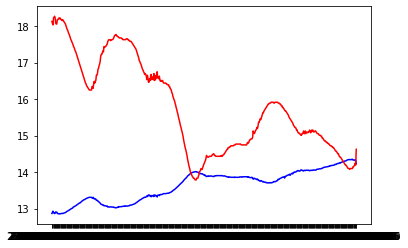

In [100]:
i = '13'
plt.plot(data[i]['pression2']['dates'], data[i]['pression2']['dH']*150, color = 'blue')
plt.plot(data[i]['pression2']['dates'], data[i]['pression2']['temperature_stream'], color = 'red')

In [95]:
data[i]['pression']['dates'].is_monotonic_increasing

True

In [103]:
dH = data[i]['pression2']['dH']*150
T = data[i]['pression2']['temperature_stream']

In [104]:
np.corrcoef(dH,T)

array([[ 1.        , -0.94584321],
       [-0.94584321,  1.        ]])

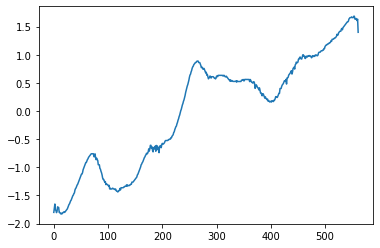

In [105]:
dH_std = (dH - np.mean(dH)) / np.std(dH)
plt.plot(dH_std)

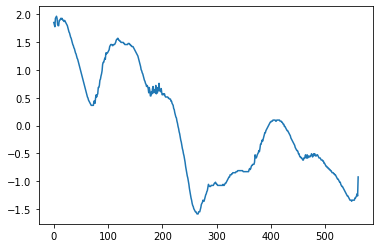

In [106]:
T_std = (T - np.mean(T)) / np.std(T)
plt.plot(T_std)

In [107]:

from sklearn.decomposition import FastICA

signals = np.vstack((dH_std, T_std))

ica = FastICA(n_components=2, whiten='unit-variance')
decorrelated_signals = ica.fit_transform(signals.T)
A = ica.mixing_
S = decorrelated_signals.dot(A.T)

indice_dH_decorr = np.argmax(np.array([np.abs(np.corrcoef(dH_std, decorrelated_signals[:,0])[0,1]),np.abs(np.corrcoef(dH_std, decorrelated_signals[:,1])[0,1])]))
sign_dh_decorr = np.sign(np.corrcoef(dH_std, decorrelated_signals[:,indice_dH_decorr])[0,1])

dH_decorr = sign_dh_decorr*decorrelated_signals[:,indice_dH_decorr]
dH_decorr_std = (dH_decorr - np.mean(dH_decorr)) / np.std(dH_decorr)

dH_cleaned = dH_decorr_std*np.std(dH) + np.mean(dH)

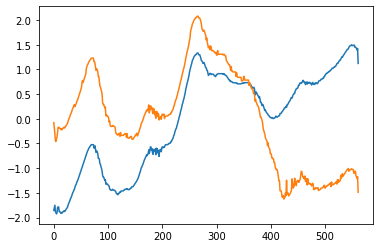

[[1.0000000e+00 1.5171731e-16]
 [1.5171731e-16 1.0000000e+00]]


In [116]:
decorr_std_signals = (decorrelated_signals - np.mean(decorrelated_signals, axis=0))/np.std(decorrelated_signals, axis=0)
plt.plot(decorr_std_signals)
#plt.plot(dH_std)
#plt.plot(-T_std)
#plt.legend(['dH decorr','T decorr','dH','T'])
plt.show()

print(np.corrcoef(decorr_std_signals[:,0],decorr_std_signals[:,1]))

In [108]:
np.corrcoef(dH_cleaned, T)

array([[ 1.        , -0.99178715],
       [-0.99178715,  1.        ]])

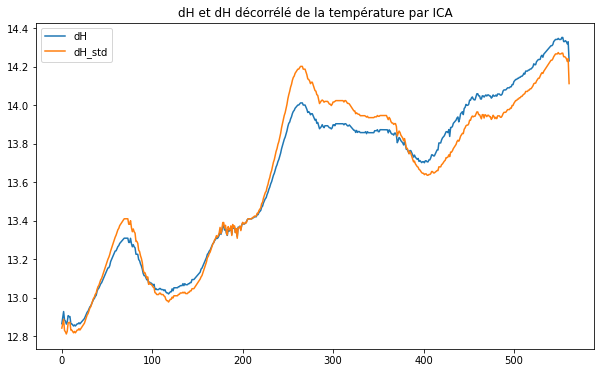

In [109]:
fig = plt.figure(figsize=(10, 6))
plt.plot(dH)
plt.plot(dH_cleaned)
plt.legend(["dH","dH_std"])
plt.title("dH et dH décorrélé de la température par ICA")
plt.show()